(67765, 192, 4) (67765,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 67597, number of used features: 768
[LightGBM] [Info] Start training from score 23.471866


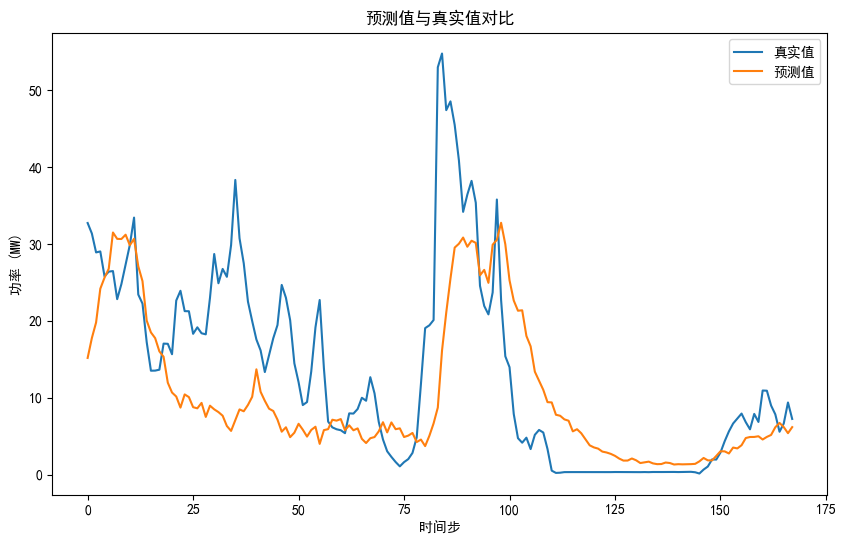

随机森林评估: {'MAE': 6.995347259082029, 'RMSE': 10.037452291371764, 'MAPE': 253.91971844443023, 'R²': 0.3602700913198752}


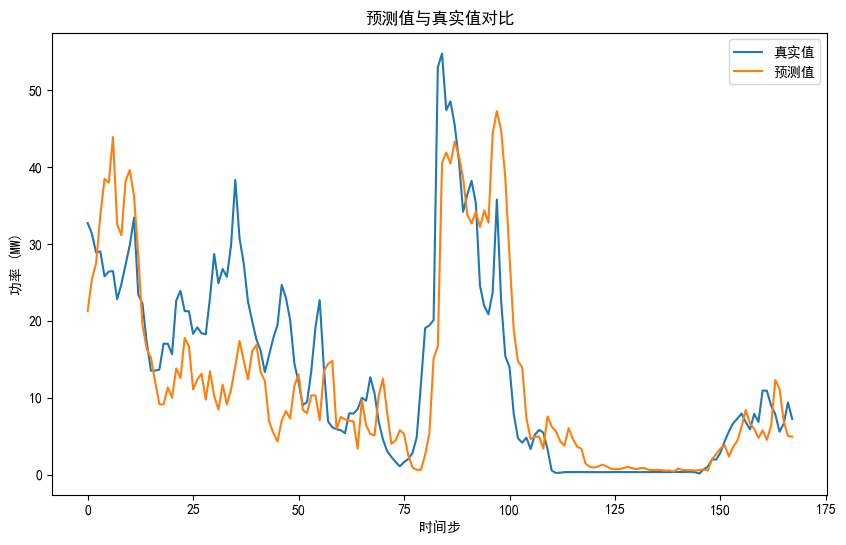

LightGBM评估: {'MAE': 5.630327165395879, 'RMSE': 8.256946975342295, 'MAPE': 135.39871001975777, 'R²': 0.567098930751663}


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

# 读取数据（假设最后一列为功率值）
df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0).iloc[:-24, 1:]  # 排除最后24行
target = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0).iloc[-24:, 1:]  # 最后24行作为目标

# 参数配置（调整后的优化参数）
n_lag = 24 * 4 * 2  # 使用12小时历史数据（原24小时减半）
n_ahead = 24     # 预测未来6小时
test_size = 24 * 7  # 测试集保持7天

# 特征选择（保留关键特征）
selected_features = [
    'Wind speed - at the height of wheel hub (m/s)',
    'Wind speed - at the height of wheel hub (˚)',
    'Air temperature  (°C) ',
    'Relative humidity (%)',
    'Power (MW)'
]
df = df[selected_features]

# 向量化滑动窗口生成函数
def create_dataset(data, n_lag, n_ahead):
    """ 
    修正后的时序数据生成函数 
    参数：
    - data: 二维数组，形状为 [样本数, 特征数]，最后一列为目标变量
    - n_lag: 历史时间步数 
    - n_ahead: 预测时间步数
    返回：
    - X: 形状为 [样本数, n_lag, 特征数-1]
    - y: 形状为 [样本数, n_ahead]
    """
    window_size = n_lag + n_ahead
    
    # 确保输入数据维度正确
    if data.ndim != 2:
        raise ValueError("输入数据必须是二维数组")
    if data.shape[1] < 1:
        raise ValueError("数据至少需要包含1个特征")
    
    # 生成滑动窗口
    windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_size,), axis=0)
    
    # 调整维度：sliding_window_view返回形状为 (N, window_size, features)
    # 需要转换为 (N - window_size + 1, window_size, features)
    windows = np.transpose(windows, (0, 2, 1))
    
    # 切片特征和目标
    X = windows[:, :n_lag, :-1]  # 前n_lag步，排除目标列
    y = windows[:, n_lag:, -1]   # 后n_ahead步，只取目标列
    # y转为一维数组
    y=y[:,0].flatten()
    return X, y

# 数据标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.iloc[:, :-1])  # 不标准化目标列
scaled_data = np.hstack([scaled_data, df[['Power (MW)']].values])  # 拼接目标列

# 生成数据集
X, y = create_dataset(scaled_data, n_lag, n_ahead)

print(X.shape,y.shape)

# 划分数据集
train_size = len(X) - test_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 展平时间维度（保持样本数，合并时间步和特征）
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 方案一：优化后的随机森林（速度提升3-5倍）
rf_model = RandomForestRegressor(
    n_estimators=100,    # 原300减至100
    max_depth=10,        # 原15减至10
    min_samples_split=10,
    max_features='sqrt', # 减少特征搜索量
    n_jobs=-1,           # 使用全部CPU核心
    random_state=42
)
rf_model.fit(X_train_flat, y_train)

# 方案二：LightGBM（速度提升10倍+）
lgb_model = LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    n_jobs=-1,
    random_state=42
)
lgb_model.fit(X_train_flat, y_train)

# 评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    r2 = r2_score(y_test, y_pred)
    
    # 对比预测值与真实值
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='真实值')
    plt.plot(y_pred, label='预测值')
    plt.legend()
    plt.title('预测值与真实值对比')
    plt.xlabel('时间步')
    plt.ylabel('功率 (MW)')
    plt.show()
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R²': r2}

# 对比评估
print("随机森林评估:", evaluate_model(rf_model, X_test_flat, y_test))
print("LightGBM评估:", evaluate_model(lgb_model, X_test_flat, y_test))

窗口验证 -> X形状: (67861, 96, 2), y形状: (67861, 24) (应有维度: X(样本, 时间步, 特征), y(样本, 预测步))
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48960
[LightGBM] [Info] Number of data points in the train set: 67837, number of used features: 192
[LightGBM] [Info] Start training from score 23.420294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48960
[LightGBM] [Info] Number of data points in the train set: 67837, number of used features: 192
[LightGBM] [Info] Start training from score 23.420293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48960
[LightGBM] [Info] Number of data

C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}

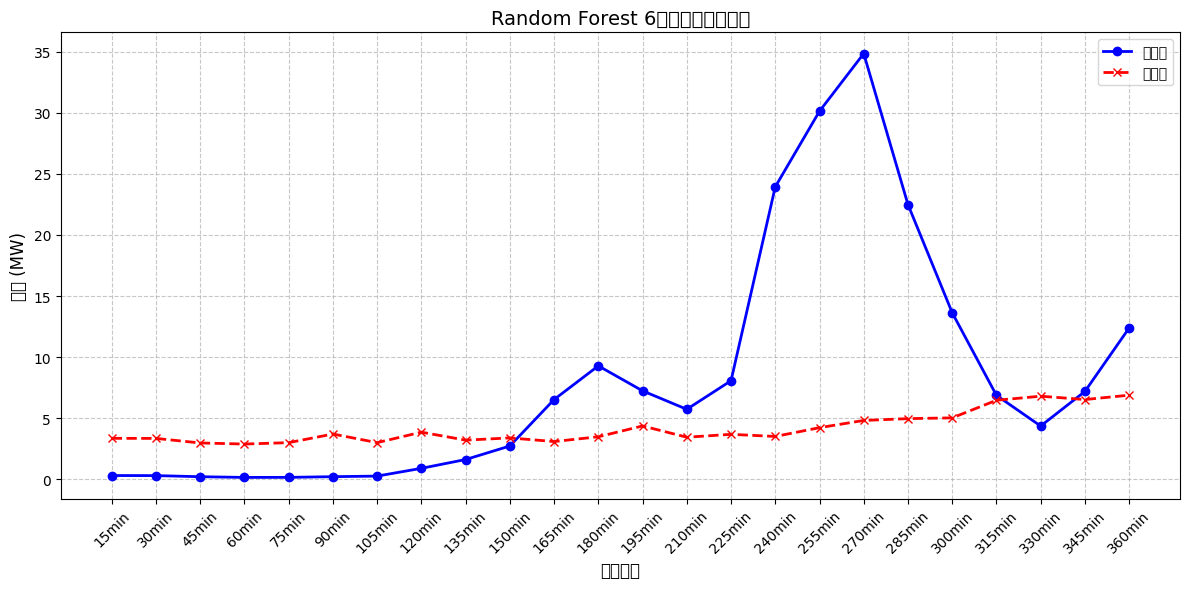

C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from current font.
  plt.tight_layout()
C:\Users\12919\AppData\Local\Temp\ipykernel_25488\2427910667.py:125: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}


LightGBM评估:
MAE: 5.989
RMSE: 9.683
R²: 0.018
LightGBM 6小时功率预测结果: [4.4901239  3.7468012  2.77785771 3.51435434 3.31006733 3.28199856
 2.33153126 3.38518261 4.25252004 4.44780067 5.58919382 4.91526958
 5.49761177 5.10523251 5.89042979 4.41809141 5.9312321  5.63682954
 7.10293703 8.01085162 6.06461266 2.87758556 3.88714132 6.7994403 ]


c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages

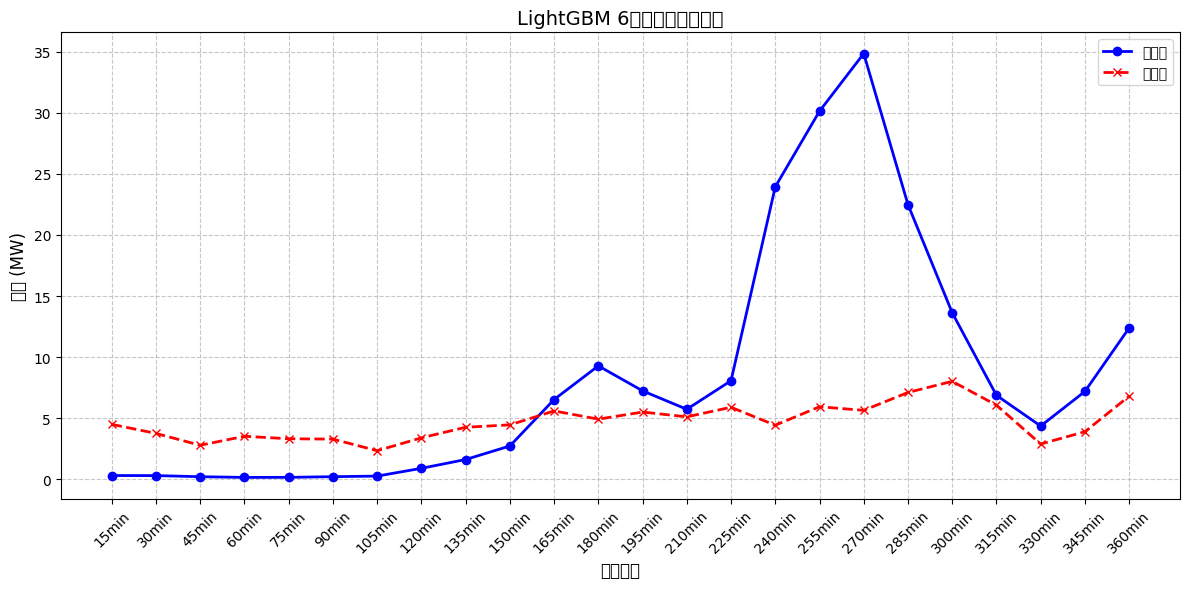

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# ----------------------
# 配置参数（清晰注释）
# ----------------------
n_lag = 24 * 4   # 历史数据时长 = 48小时（每15分钟一个点）
n_ahead = 24         # 预测未来6小时（24个15分钟间隔）
test_size = 24       # 测试集大小与预测窗口对齐

# ----------------------
# 数据预处理（分步骤注释）
# ----------------------
# 读取数据（明确分离特征和目标）
df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv', header=0)

selected_features = [
    'Wind speed - at the height of wheel hub (m/s)',
    'Air temperature  (°C) ',
    'Relative humidity (%)',
    'Power (MW)'  # 目标列
]
df = df[selected_features]

raw_features = df.iloc[:-24, 1:-1]  # 排除最后24行和目标列
raw_target = df.iloc[:-24, -1]      # 目标列（功率）
target_future = df.iloc[-24:, -1]   # 最后24行真实值

# 标准化特征（保留原始目标值）
scaler = StandardScaler()
scaled_features = scaler.fit_transform(raw_features)

# 重构为带时间步的数据框（提升可读性）
time_series_df = pd.DataFrame(
    data=np.hstack([scaled_features, raw_target.values.reshape(-1, 1)]),
    columns=df.columns[1:-1].tolist() + ['Power (MW)']
)




# ----------------------
# 滑动窗口生成（逐步构建）
# ----------------------
def create_rolling_windows(data, n_lag, n_ahead):
    """生成时序样本的滚动窗口
    
    参数:
    - data: 二维数组 [时间步, 特征+目标]
    - n_lag: 历史时间步数 
    - n_ahead: 预测时间步数
    
    返回:
    - X: 输入特征 [样本数, n_lag, 特征数]
    - y: 输出目标 [样本数, n_ahead]
    """
    total_samples = len(data) - n_lag - n_ahead + 1
    n_features = data.shape[1] - 1  # 最后一列是目标
    
    # 预分配内存（明确维度）
    X = np.zeros((total_samples, n_lag, n_features))
    y = np.zeros((total_samples, n_ahead))
    
    # 显式滑动窗口构建（避免复杂转置）
    for i in range(total_samples):
        window = data[i : i + n_lag + n_ahead]
        X[i] = window[:n_lag, :-1]      # 历史特征
        y[i] = window[n_lag:, -1]       # 未来目标
        
    return X, y

# 生成窗口并验证形状
X, y = create_rolling_windows(time_series_df.values, n_lag, n_ahead)
print(f"窗口验证 -> X形状: {X.shape}, y形状: {y.shape} (应有维度: X(样本, 时间步, 特征), y(样本, 预测步))")

# ----------------------
# 模型训练（保持Flat格式）
# ----------------------
# 展平时间维度（添加注释说明）
X_flat = X.reshape(X.shape[0], -1)  # 形状变为 (样本数, n_lag * 特征数)

# 数据集划分
X_train, X_test = X_flat[:-test_size], X_flat[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# 初始化模型（添加参数说明）
models = {
    "Random Forest": MultiOutputRegressor(
        RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    ),
    "LightGBM": MultiOutputRegressor(
        LGBMRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, n_jobs=-1, random_state=42)
    )
}

# 训练并预测
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# ----------------------
# 可视化评估（增强可读性）
# ----------------------
def plot_power_forecast(model_name, pred, true):
    """绘制功率预测对比图"""
    time_labels = [f"{(i+1)*15}min" for i in range(n_ahead)]
    print(f"{model_name} 6小时功率预测结果: {pred[0]}")
    plt.figure(figsize=(12, 6))
    plt.plot(time_labels, true, 'bo-', label='真实值', linewidth=2)
    plt.plot(time_labels, pred[0], 'rx--', label='预测值', linewidth=2)  # 取第一个测试样本
    
    plt.title(f"{model_name} 6小时风电功率预测", fontsize=14)
    plt.xlabel("预测时点", fontsize=12)
    plt.ylabel("功率 (MW)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 获取真实值（确保顺序正确）
true_power = target_future.values[:n_ahead]

# 输出评估结果
for model_name, pred in predictions.items():
    print(f"\n{model_name}评估:")
    print("MAE:", round(mean_absolute_error(true_power, pred[0]), 3))
    print("RMSE:", round(np.sqrt(mean_squared_error(true_power, pred[0])), 3))
    print("R²:", round(r2_score(true_power, pred[0]), 3))
    plot_power_forecast(model_name, pred, true_power)